# Ted Talks

Two datasets:
- `ted_main.csv`
- `transcript.csv`


In [348]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews, twitter_samples

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier

import re, string, random


from ast import literal_eval

# Uncomment this if you want to see all rows and columns when displaying a pandas object
# pd.set_option("display.max_rows", None, "display.max_columns", None)

## Part A. Data loading and preprocessing

In [349]:
df = pd.read_csv('data/ted_main.csv')
df2 = pd.read_csv('data/transcripts.csv')
df2.info()
df.info()

df = pd.merge(df, df2, on='url', how='left') #add the transcription to the data


print('We have ' + str(df.shape[0]) + ' data points')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467 entries, 0 to 2466
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   transcript  2467 non-null   object
 1   url         2467 non-null   object
dtypes: object(2)
memory usage: 38.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2550 non-null   int64 
 1   description         2550 non-null   object
 2   duration            2550 non-null   int64 
 3   event               2550 non-null   object
 4   film_date           2550 non-null   int64 
 5   languages           2550 non-null   int64 
 6   main_speaker        2550 non-null   object
 7   name                2550 non-null   object
 8   num_speaker         2550 non-null   int64 
 9   published_date      2550 non-null   int64 
 10  ratin

The dataset contains 17 columns. According to the Kaggle website these are:
<ol>
    <li> <b>name</b>: The official name of the TED Talk. Includes the title and the speaker. *Use this as the unique id in our dataframe </li>
    <li> <b>title</b>: The title of the talk </li>
    <li> <b>main_speaker</b>: The first named speaker of the talk </li>    
    <li> <b>speaker_occupation</b>: The occupation of the main speaker </li>
    <li> <b>num_speaker</b>: The number of speakers in the talk </li>
    <li> <b>description</b>: A blurb of what the talk is about </li>
    <li> <b>duration</b>: The duration of the talk in seconds </li>
    <li> <b>event</b>: The TED/TEDx event where the talk took place </li>
    <li> <b>languages</b>: The number of languages in which the talk is available </li>
    <li> <b>film_date</b>: The Unix timestamp of the filming </li>
    <li> <b>published_date</b>: The Unix timestamp for the publication of the talk on TED.com </li>
    <li> <b>tags</b>: The themes associated with the talk </li>
    <li> <b>views</b>: The number of views on the talk </li>
    <li> <b>url</b>: The URL of the talk </li>
    <li> <b>ratings</b>: A stringified dictionary of the various ratings given to the talk (inspiring, fascinating, jaw dropping, etc.) </li>
    <li> <b>comments</b> The number of first level comments made on the talk </li>
    <li> <b>related_talks</b> A list of dictionaries of recommended talks to watch next </li>
</ol>


In [350]:
display(df.head(5))

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,Good morning. How are you?(Laughter)It's been ...
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,"Thank you so much, Chris. And it's truly a gre..."
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,If you're here today — and I'm very happy that...
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,"About 10 years ago, I took on the task to teac..."


### Missing data? Not much :D

In [351]:
df.isnull().sum()

comments               0
description            0
duration               0
event                  0
film_date              0
languages              0
main_speaker           0
name                   0
num_speaker            0
published_date         0
ratings                0
related_talks          0
speaker_occupation     6
tags                   0
title                  0
url                    0
views                  0
transcript            86
dtype: int64

Quite many are missing transcription for some reason. Fill this missing data with an empty string. We could manually search each one on Wikipedia and manually fill in this information.

In [352]:
df.transcript.fillna('', inplace=True)

Only some speakers do not have their occupations in the dataset. We could manually search each one on Wikipedia and manually fill in this information.
Replaced them with "Unknown" for now.

In [353]:
display(df[df.isnull().any(axis=1)])
df.speaker_occupation.fillna('Unknown', inplace = True)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
1113,145,"After a crisis, how can we tell if water is sa...",217,TEDGlobal 2011,1310601600,38,Sonaar Luthra,Sonaar Luthra: Meet the Water Canary,1,1326731605,"[{'id': 10, 'name': 'Inspiring', 'count': 73},...","[{'id': 523, 'hero': 'https://pe.tedcdn.com/im...",NaN,"['TED Fellows', 'design', 'global development'...",Meet the Water Canary,https://www.ted.com/talks/sonaar_luthra_meet_t...,353749,Cholera was reported in Haiti for the first ti...
1195,122,"The Pirate Party fights for transparency, anon...",1097,TEDxObserver,1331424000,10,Rick Falkvinge,Rick Falkvinge: I am a pirate,1,1333289675,"[{'id': 8, 'name': 'Informative', 'count': 156...","[{'id': 1329, 'hero': 'https://pe.tedcdn.com/i...",NaN,"['Internet', 'TEDx', 'global issues', 'politic...",I am a pirate,https://www.ted.com/talks/rick_falkvinge_i_am_...,181010,Thank y'all!This is going to be a motivational...
1223,257,"As you surf the Web, information is being coll...",399,TED2012,1330473600,32,Gary Kovacs,Gary Kovacs: Tracking our online trackers,1,1336057219,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 9...","[{'id': 1370, 'hero': 'https://pe.tedcdn.com/i...",NaN,"['Internet', 'advertising', 'business', 'priva...",Tracking our online trackers,https://www.ted.com/talks/gary_kovacs_tracking...,2098639,"I don't know why, but I'm continually amazed t..."
1659,140,"In this lovely talk, TED Fellow Ryan Holladay ...",389,TED@BCG San Francisco,1383091200,33,Ryan Holladay,Ryan Holladay: To hear this music you have to ...,1,1389369735,"[{'id': 1, 'name': 'Beautiful', 'count': 211},...","[{'id': 1152, 'hero': 'https://pe.tedcdn.com/i...",NaN,"['TED Fellows', 'entertainment', 'music', 'tec...",To hear this music you have to be there. Liter...,https://www.ted.com/talks/ryan_holladay_to_hea...,1284510,(Music) For any of you who have visited or liv...
1914,48,What do you do with an outdated encyclopedia i...,366,TEDYouth 2014,1415059200,34,Brian Dettmer,Brian Dettmer: Old books reborn as art,1,1423238442,"[{'id': 1, 'name': 'Beautiful', 'count': 361},...","[{'id': 610, 'hero': 'https://pe.tedcdn.com/im...",NaN,"['TEDYouth', 'art', 'books', 'creativity']",Old books reborn as art,https://www.ted.com/talks/brian_dettmer_old_bo...,1159937,I'm an artist and I cut books. This is one of ...
1952,70,Photographer Boniface Mwangi wanted to protest...,440,TEDGlobal 2014,1413763200,33,Boniface Mwangi,Boniface Mwangi: The day I stood up alone,1,1427989423,"[{'id': 3, 'name': 'Courageous', 'count': 614}...","[{'id': 1757, 'hero': 'https://pe.tedcdn.com/i...",NaN,"['TED Fellows', 'activism', 'art', 'corruption...",The day I stood up alone,https://www.ted.com/talks/boniface_mwangi_boni...,1342431,"People back home call me a heckler, a troublem..."


## Preprocessing
<ol>
    <li>transform the <b>film_date</b> and <b>publish_date</b> into datetime objects</li>
    <li>transform the <b>tags</b>, <b>rratings</b> and <b>related_talks</b> stringified dictionary into dictionary objects</li>
    <li>expand the <b>ratings</b> column in different columns </li>
    <li>reorder columns in a more intuitive order</li>
    <li>fill in missing values for speaker_occupation column</li>
    <li>constuct related talks graph</li>
    <li>transcription list of words</li>
    <li>speed ot talk</li>
    <li></li>

</ol>
    

### natural language processing

In [354]:
## WITH MOVIE SAMPLES
def extract_features(word_list):
  return dict([(word, True) for word in word_list])

## WITH MOVIE REVIEWS
positive_fileids = movie_reviews.fileids('pos')
negative_fileids = movie_reviews.fileids('neg')

features_positive = [(extract_features(movie_reviews.words(fileids=[f])), 
           'Positive') for f in positive_fileids]
features_negative = [(extract_features(movie_reviews.words(fileids=[f])), 
           'Negative') for f in negative_fileids]

threshold_factor = 0.8
threshold_positive = int(threshold_factor * len(features_positive))
threshold_negative = int(threshold_factor * len(features_negative))


features_train = features_positive[:threshold_positive] + features_negative[:threshold_negative]
features_test = features_positive[threshold_positive:] + features_negative[threshold_negative:]  
print( "\nNumber of training datapoints:", len(features_train))
print( "Number of test datapoints:", len(features_test))


classifier = NaiveBayesClassifier.train(features_train)

print("\nTop 10 most informative words:")
for item in classifier.most_informative_features()[:10]:
   print(item[0])
    
input_reviews = df.transcript




Number of training datapoints: 1600
Number of test datapoints: 400

Top 10 most informative words:
outstanding
insulting
vulnerable
ludicrous
uninvolving
astounding
avoids
fascination
symbol
affecting


In [355]:
## WITH TWITTER SAMPLES
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []
    for token, tag in pos_tag(tweet_tokens):
        #token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
        #               '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        #token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)
        
        
        

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]

stop_words = stopwords.words('english')

positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

all_pos_words = get_all_words(positive_cleaned_tokens_list)

freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(10))

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))


[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253)]
Accuracy is: 0.9956666666666667
Most Informative Features
                      :( = True           Negati : Positi =   2051.8 : 1.0
                      :) = True           Positi : Negati =   1005.8 : 1.0
                     sad = True           Negati : Positi =     24.9 : 1.0
                follower = True           Positi : Negati =     24.7 : 1.0
                  arrive = True           Positi : Negati =     21.9 : 1.0
                     bam = True           Positi : Negati =     20.4 : 1.0
                followed = True           Negati : Positi =     14.1 : 1.0
                    glad = True           Positi : Negati =     13.5 : 1.0
                  friday = True           Positi : Negati =     12.7 : 1.0
               community = True           Positi : Negati =     12.4 : 1.0
None


Predicted sentiment: Positive
Probability: 1.0


In [365]:
input_reviews = df.transcript

twitter_sentiment = []
movie_sentiment = []


for i in range(len(input_reviews)):
   if(i%50==0) print(i)
   review = input_reviews[i]
   custom_tokens = remove_noise(word_tokenize(review))
   probdist = classifier.prob_classify(dict([token, True] for token in custom_tokens))
   pred_sentiment = probdist.max()
     
   #print( "Predicted sentiment:", pred_sentiment )
   factor = 1 if pred_sentiment == "Positive" else -1
   prob = round(probdist.prob(pred_sentiment), 7)
   #print( "Probability:", prob)
   twitter_sentiment.append(factor * prob)

print('first part doned')
for review in input_reviews:
   probdist = classifier.prob_classify(extract_features(review.split()))
   pred_sentiment = probdist.max()
     
   factor = 1 if pred_sentiment == "Positive" else -1
   prob = round(probdist.prob(pred_sentiment), 7)
   movie_sentiment.append(factor * prob)
   

df['twitter_sentiment'] = twitter_sentiment
df['movie_sentiment'] = movie_sentiment
print('second part doned')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [368]:
df['number_of_words'] = df['transcript'].apply(lambda x: len(x.split()) )
df['duration'] = df['duration']/60

df['speed_of_speech'] = df['number_of_words'] / df['duration']
print('doned')


doned


### NORMAL EDITINGS

In [369]:
# Transform the film_date and publish_date to datetime objects
# Keep only the day month and year
df['film_date'] = pd.to_datetime(df['film_date'], unit='s').dt.strftime('%d/%m/%Y')
df['published_date'] = pd.to_datetime(df['published_date'], unit='s').dt.strftime('%d/%m/%Y')
df['film_date'] = pd.to_datetime(df['film_date'])
df['published_date'] = pd.to_datetime(df['published_date'])

# Tranfrom stringified dictionary to actual dictionary and stringified list to actual list
df['tags'] = df['tags'].apply(lambda x: literal_eval(x))
df['ratings'] = df['ratings'].apply(lambda x: literal_eval(x))
df['related_talks'] = df['related_talks'].apply(lambda x: literal_eval(x))

In [370]:
# ratings
def extract_ratings_name(x):
    rating_names = []
    for rating in x:
        rating_names.append(str(rating['name']).lower())
    rating_names.sort()
    return rating_names

ratings_name = extract_ratings_name(df.iloc[0][['ratings']][0])
print('For each rating we have ' + str(len(ratings_name)) + ' categories: ' + str(ratings_name))
print('One rating has the following attributes: ' + str(df.iloc[0][['ratings']][0][0]))
 
for index, row in df.iterrows():
    for item in row['ratings']:
        df.loc[index, item['name'].lower()] = int(item['count'])
display(df[['name'] + ratings_name])        

For each rating we have 14 categories: ['beautiful', 'confusing', 'courageous', 'fascinating', 'funny', 'informative', 'ingenious', 'inspiring', 'jaw-dropping', 'longwinded', 'obnoxious', 'ok', 'persuasive', 'unconvincing']
One rating has the following attributes: {'id': 7, 'name': 'Funny', 'count': 19645}


,name,beautiful,confusing,courageous,fascinating,funny,informative,ingenious,inspiring,jaw-dropping,longwinded,obnoxious,ok,persuasive,unconvincing
0,Ken Robinson: Do schools kill creativity?,4573.0,242.0,3253.0,10581.0,19645.0,7346.0,6073.0,24924.0,4439.0,387.0,209.0,1174.0,10704.0,300.0
1,Al Gore: Averting the climate crisis,58.0,62.0,139.0,132.0,544.0,443.0,56.0,413.0,116.0,113.0,131.0,203.0,268.0,258.0
2,David Pogue: Simplicity sells,60.0,27.0,45.0,166.0,964.0,395.0,183.0,230.0,54.0,78.0,142.0,146.0,230.0,104.0
3,Majora Carter: Greening the ghetto,291.0,32.0,760.0,132.0,59.0,380.0,105.0,1070.0,230.0,53.0,35.0,85.0,460.0,36.0
4,Hans Rosling: The best stats you've ever seen,942.0,72.0,318.0,4606.0,1390.0,5433.0,3202.0,2893.0,3736.0,110.0,61.0,248.0,2542.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2548,Duarte Geraldino: What we're missing in the de...,21.0,2.0,24.0,8.0,1.0,33.0,22.0,27.0,14.0,3.0,1.0,0.0,24.0,12.0
2549,Armando Azua-Bustos: The most Martian place on...,4.0,0.0,2.0,32.0,20.0,38.0,6.0,20.0,8.0,0.0,0.0,13.0,7.0,1.0
2550,Radhika Nagpal: What intelligent machines can ...,14.0,5.0,2.0,24.0,1.0,32.0,19.0,30.0,1.0,0.0,0.0,4.0,3.0,1.0
2551,Theo E.J. Wilson: A black man goes undercover ...,21.0,1.0,107.0,39.0,63.0,75.0,37.0,147.0,7.0,3.0,7.0,5.0,65.0,6.0


In [371]:
# Reorder columns
df = df[['name', 'title', 'main_speaker', 'speaker_occupation', 'num_speaker', 'description', \
         'duration', 'number_of_words', 'movie_sentiment', 'twitter_sentiment', \
         'speed_of_speech', 'event', 'languages', 'film_date', 'published_date', 'tags', 'views', \
         'url', 'ratings', 'comments', 'related_talks', 'beautiful', 'confusing', 'courageous', \
         'fascinating', 'funny', 'informative', 'ingenious', 'inspiring', 'jaw-dropping', \
         'longwinded', 'ok', 'obnoxious', 'persuasive', 'unconvincing']]
display(df.head(5))

,name,title,main_speaker,speaker_occupation,num_speaker,description,duration,number_of_words,movie_sentiment,twitter_sentiment,...,funny,informative,ingenious,inspiring,jaw-dropping,longwinded,ok,obnoxious,persuasive,unconvincing
0,Ken Robinson: Do schools kill creativity?,Do schools kill creativity?,Ken Robinson,Author/educator,1,Sir Ken Robinson makes an entertaining and pro...,19.400000,3066,1.0,1.000000,...,19645.0,7346.0,6073.0,24924.0,4439.0,387.0,1174.0,209.0,10704.0,300.0
1,Al Gore: Averting the climate crisis,Averting the climate crisis,Al Gore,Climate advocate,1,With the same humor and humanity he exuded in ...,16.283333,2089,1.0,1.000000,...,544.0,443.0,56.0,413.0,116.0,113.0,203.0,131.0,268.0,258.0
2,David Pogue: Simplicity sells,Simplicity sells,David Pogue,Technology columnist,1,New York Times columnist David Pogue takes aim...,21.433333,3253,1.0,-0.986247,...,964.0,395.0,183.0,230.0,54.0,78.0,146.0,142.0,230.0,104.0
3,Majora Carter: Greening the ghetto,Greening the ghetto,Majora Carter,Activist for environmental justice,1,"In an emotionally charged talk, MacArthur-winn...",18.600000,3015,1.0,1.000000,...,59.0,380.0,105.0,1070.0,230.0,53.0,85.0,35.0,460.0,36.0
4,Hans Rosling: The best stats you've ever seen,The best stats you've ever seen,Hans Rosling,Global health expert; data visionary,1,You've never seen data presented like this. Wi...,19.833333,3121,1.0,1.000000,...,1390.0,5433.0,3202.0,2893.0,3736.0,110.0,248.0,61.0,2542.0,67.0


In [372]:
# speaker_occupation
print('We have ' + str(df['speaker_occupation'].nunique()) + ' different occupations')
display(df['speaker_occupation'].value_counts())
# Fill in missing data
df['speaker_ocupation'] = df['speaker_occupation'].str.lower()
# Taken from TED website
df.loc[df['main_speaker'] == 'Sonar Luthra', 'speaker_occupation'] = 'water data wrangler'
df.loc[df['main_speaker'] == 'Ryan Holladay', 'speaker_occupation'] = 'musician'
# Taken from Wikipedia
df.loc[df['main_speaker'] == 'Rick Falkvinge', 'speaker_occupation'] = 'it entrepreneur, politician'
df.loc[df['main_speaker'] == 'Gary Kovacs', 'speaker_occupation'] = 'ceo'
df.loc[df['main_speaker'] == 'Brian Dettmer', 'speaker_occupation'] = 'artist'
df.loc[df['main_speaker'] == 'Boniface Mwangi', 'speaker_occupation'] = 'photojournalist'

We have 1459 different occupations


Writer                            45
Artist                            34
Designer                          34
Journalist                        33
Entrepreneur                      31
                                  ..
Baker                              1
Genomics researcher                1
Conservationists, filmmakers       1
Director of The British Museum     1
Music producer and DJ              1
Name: speaker_occupation, Length: 1459, dtype: int64

In [373]:
df['related_talks'] = df['related_talks'].apply(lambda x: x[:2])

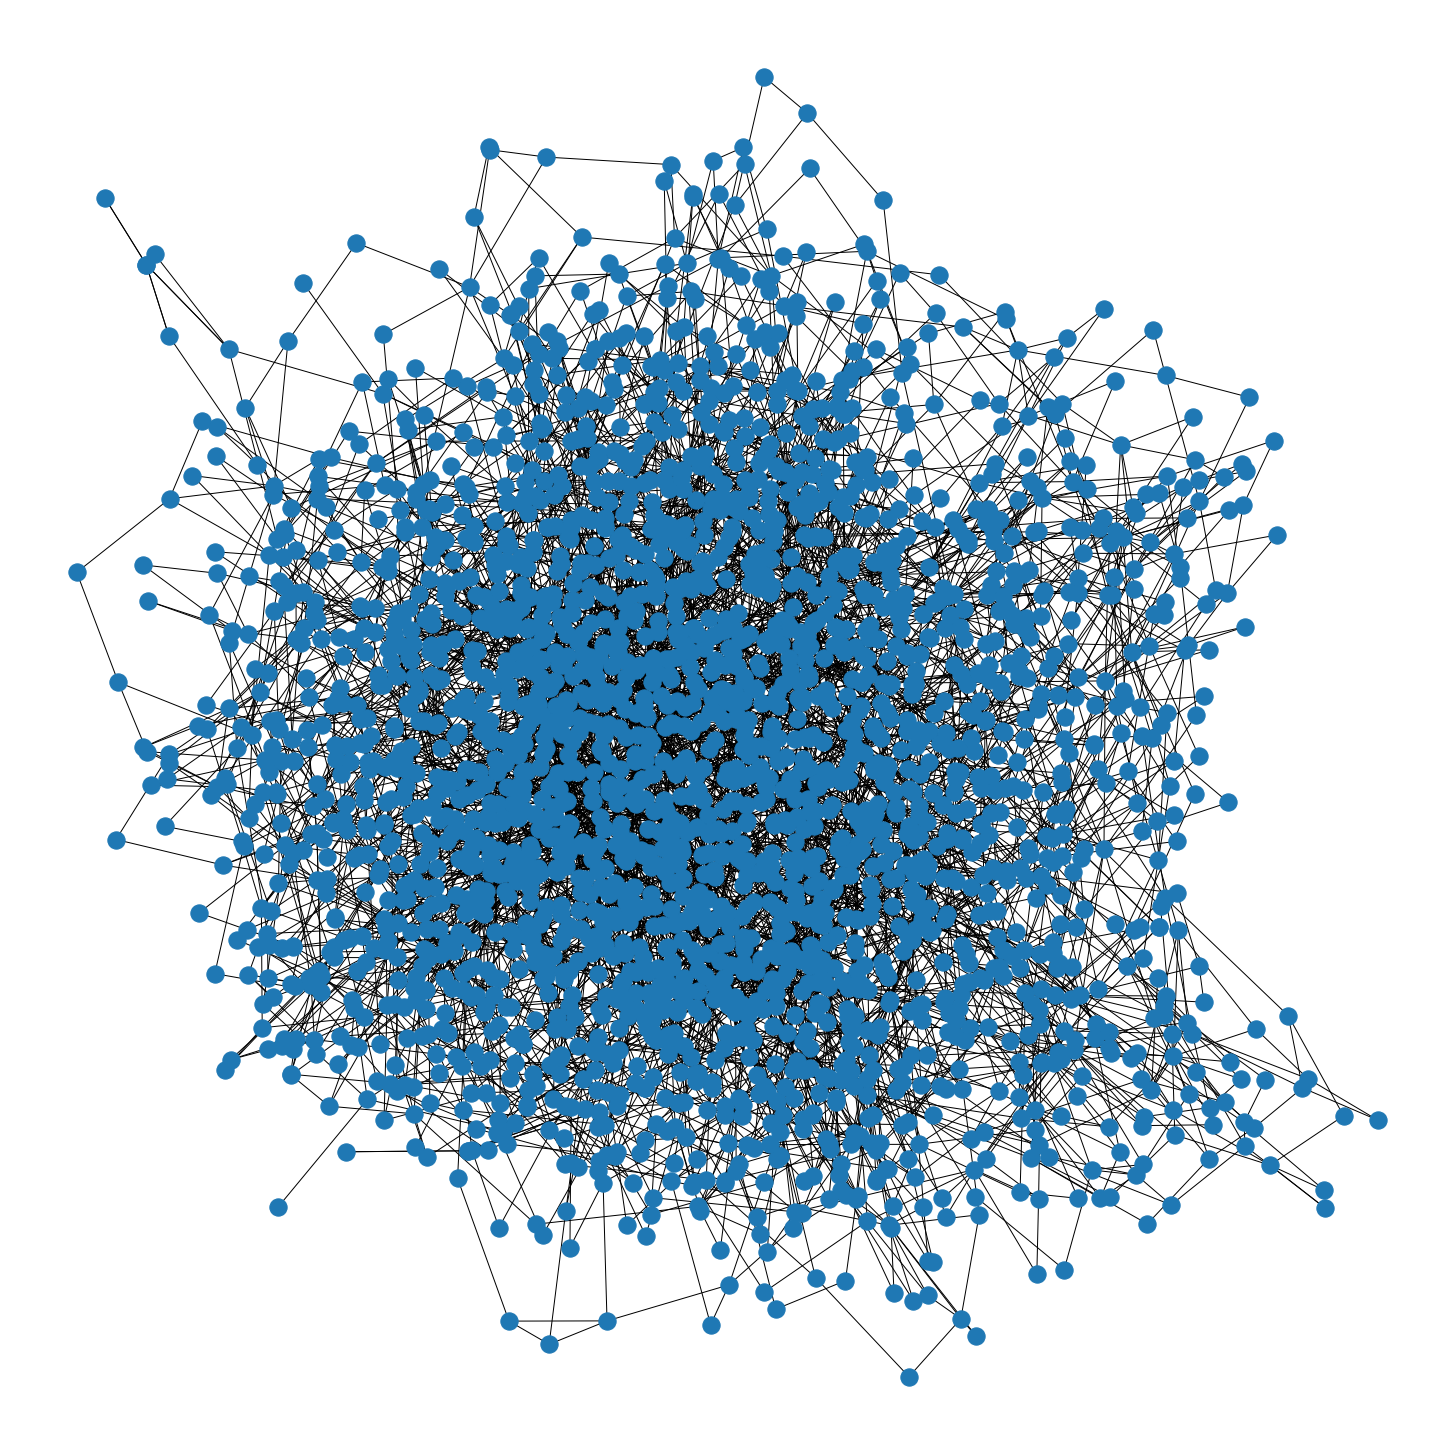

In [374]:
# related_talks
#display(df.iloc[0][['related_talks']][0][0])
unstack_edges = df.apply(lambda x: pd.Series(x['related_talks']), axis=1).stack().reset_index(level=1, drop=True)
unstack_edges.name = 'related_talk'

edges = df.drop('related_talks', axis=1).join(unstack_edges)[['title', 'related_talk']]
edges['related_talk'] = edges['related_talk'].apply(lambda x: x['title'])
edges.rename(columns = {'title': 'source', 'related_talk': 'target'}, inplace=True)
talksG = nx.from_pandas_edgelist(edges, 'source', 'target', edge_attr=None, create_using=nx.Graph())
plt.figure(figsize=(20, 20))
nx.draw(talksG, with_labels=False)

In [375]:
talksG.number_of_edges()

4930

In [376]:
talksG.number_of_nodes()

2550

In [377]:
nx.number_connected_components(talksG)

1

In [378]:
# Give ids
df['talk_id'] = df.index
edges = edges.merge(df, left_on='source', right_on='title')[['source', 'target', 'talk_id']]
edges = edges.merge(df, left_on='target', right_on='title')[['source', 'target', 'talk_id_x', 'talk_id_y']]
edges.rename(columns={'id_x': 'source_id', 'id_y': 'target_id'}, inplace=True)
edges.head(5)

,source,target,talk_id_x,talk_id_y
0,Do schools kill creativity?,Bring on the learning revolution!,0,692
1,The child-driven education,Bring on the learning revolution!,760,692
2,How web video powers global innovation,Bring on the learning revolution!,766,692
3,Changing education paradigms,Bring on the learning revolution!,833,692
4,A short intro to the Studio School,Bring on the learning revolution!,1023,692


In [379]:
# Some nodes were manually changed since " or ' or , characters were not escaped properly in d3
# Required further investigation
# Uncommenting these lines would result in changing these files
# PROCEED WITH CAUTION
#file = open('resources/edges.tsv', 'w')
#file.write('source\ttarget\n')
#for edge in talksG.edges:
#    source_id = df[df['title'] == edge[0]]['id'].values[0]
#    target_id = df[df['title'] == edge[1]]['id'].values[0]
#    file.write('{0}\t{1}\n'.format(source_id, target_id))
#file.close()

In [380]:
# Some nodes were manually changed since " or ' or , characters were not escaped properly in d3
# Required further investigation
# Uncommenting these lines would result in changing these files
# PROCEED WITH CAUTION
#file = open('resources/nodes.tsv', 'w')
#file.write('title\tid\n')
#for node in talksG.nodes:
#    node_id = df[df['title'] == node]['id'].values[0]
#    file.write('{0}\t{1}\n'.format(node, node_id))
#file.close()

In [381]:
df.to_csv('resources/ted_main.csv', index=False, header=True)

### Saving information about the speakers in a different file

In [382]:
speaker = df[['main_speaker', 'speaker_occupation', 'title', 'views', 'talk_id', 'speed_of_speech']]
speaker = speaker.groupby(['main_speaker', 'speaker_occupation'], as_index=False).agg({
    'views': 'sum',
    'speed_of_speech': 'sum',
    'title': 'count',
    'talk_id': lambda x: x.tolist()
})
speaker['total_views'] = speaker['views']
speaker['views'] = speaker['views'] / speaker['title']
speaker['speed_of_speech'] = speaker['speed_of_speech'] / speaker['title']
speaker['views'] = speaker['views'].apply(lambda x: '%.3f' % x).values.tolist()
speaker.rename(columns={'main_speaker': 'speaker', 'total_views': 'total_views', 'views': 'avg_views', 'speed_of_speech': 'avg_speed_of_speech', 'title': 'nof_talks', 'talk_id': 'talks'}, inplace=True)
speaker['speaker_id'] = speaker.index
speaker.to_csv('resources/speaker.csv', index=False, header=True)
speaker.head(5)

,speaker,speaker_occupation,avg_views,avg_speed_of_speech,nof_talks,talks,total_views,speaker_id
0,OK Go,Band,1493866.000,129.440758,1,[2463],1493866,0
1,Rodrigo y Gabriela,Guitar duo,1138566.000,0.933852,1,[2385],1138566,1
2,Silk Road Ensemble,Musical explorers,640734.000,0.000000,1,[2410],640734,2
3,Sofi Tukker,Band,815611.000,75.000000,1,[2479],815611,3
4,AJ Jacobs,Author,1622792.667,146.010577,3,"[261, 1100, 1769]",4868378,4


In [383]:
df[df['speaker_occupation'] == 'Band'][['main_speaker', 'views']].head(5)

,main_speaker,views
222,They Might Be Giants,362609
2463,OK Go,1493866
2479,Sofi Tukker,815611


In [384]:
speaker.dtypes

speaker                 object
speaker_occupation      object
avg_views               object
avg_speed_of_speech    float64
nof_talks                int64
talks                   object
total_views              int64
speaker_id               int64
dtype: object

## Part B. Exploratory data analysis

### main_speaker
Questions:
<ol>
    <li>How many talks does each speaker do?</li>
    <li>Which speakers do the most talks? (first 10)</li>
</ol>

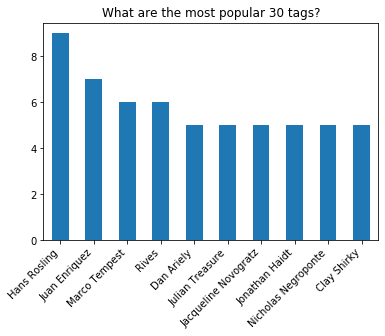

In [276]:
df['main_speaker'].value_counts().sort_values(ascending=False)[:10].plot.bar()
plt.title('What are the most popular 30 tags?')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

### num_speaker
Questions:
<ol>
    <li>What's the distribution of number of speakers? Look at percentages.</li>
</ol>

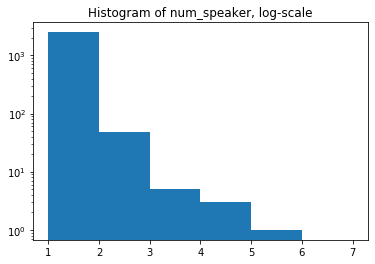

Percentages:


1    97.728163
2     1.919311
3     0.195848
4     0.117509
5     0.039170
Name: num_speaker, dtype: float64

In [277]:
df['num_speaker'].hist(grid=False, bins=range(1, 8))
plt.yscale('log')
plt.title('Histogram of num_speaker, log-scale')
plt.show()

print('Percentages:')
df['num_speaker'].value_counts(normalize=True)*100

### duration
Questions:
<ol>
    <li>What's the distribution of number of speakers?</li>
    <li>Which are the 10 longest talks?</li>
    <li>Which are the 10 shortest talks?</li>
    <li>Average duration</li>
</ol>

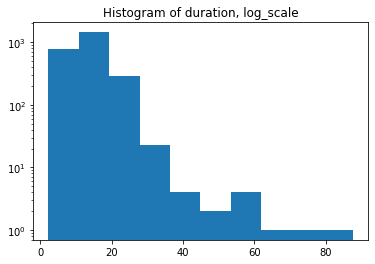

Average duration: 13.776250163206683


In [278]:
fig, ax = plt.subplots(1, 1)

ax.hist(df['duration'])
ax.set_yscale('log')
ax.set_title('Histogram of duration, log_scale')
plt.show()

print('Average duration: ' + str(df['duration'].mean()))

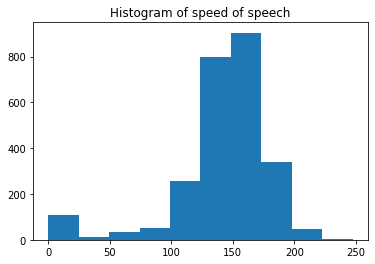

Average speed_of_speech: 142.14775245831498


In [279]:

fig, ax = plt.subplots(1, 1)

ax.hist(df['speed_of_speech'])
ax.set_title('Histogram of speed of speech')
plt.show()

print('Average speed_of_speech: ' + str(df['speed_of_speech'].mean()))

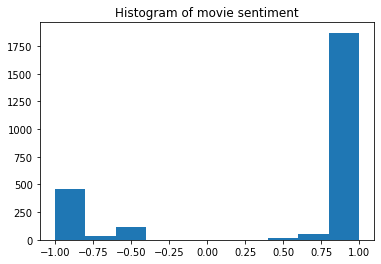

Average movie sentiment: 0.5393834287504896


In [366]:

fig, ax = plt.subplots(1, 1)

ax.hist(df['movie_sentiment'])
ax.set_title('Histogram of movie sentiment')
plt.show()

print('Average movie sentiment: ' + str(df['movie_sentiment'].mean()))

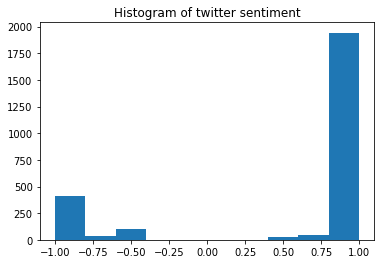

Average twitter sentiment: 0.5858009533098316


In [367]:

fig, ax = plt.subplots(1, 1)

ax.hist(df['c'])
ax.set_title('Histogram of twitter sentiment')
plt.show()

print('Average twitter sentiment: ' + str(df['twitter_sentiment'].mean()))

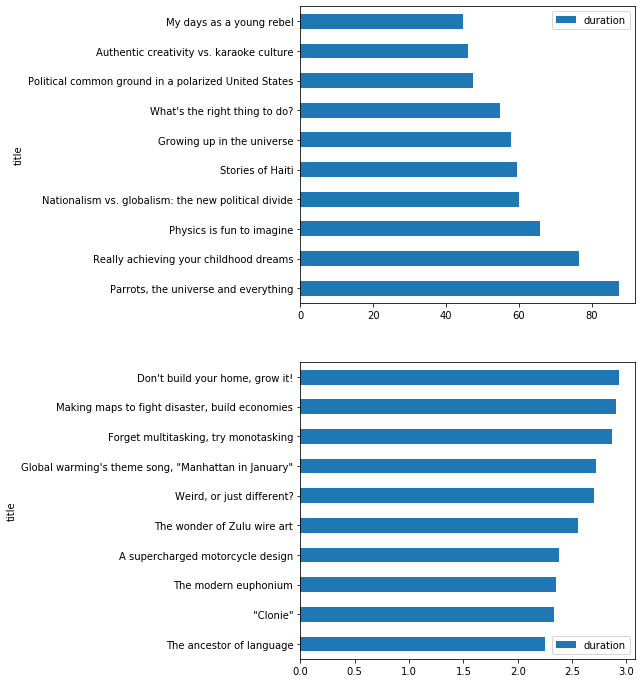

In [282]:
fig, ax = plt.subplots(2, 1, figsize=(6, 12))

bar_plot0 = df[['title', 'duration']].sort_values(by='duration', ascending=False)[:10]
bar_plot0.plot.barh(x='title', y='duration', ax=ax[0])

bar_plot1 = df[['title', 'duration']].sort_values(by='duration')[:10]
bar_plot1.plot.barh(x='title', y='duration', ax=ax[1])
plt.show()

### event
Questions:
<ol>
    <li>How many events do we have?</li>
    <li>How many TEDx events are?</li>
    <li>Which are the first 10 events based on number of talks?</li>
    <li>How many events have only one talk?</li>
</ol>

Number of events: 355
Number of TEDx events: 205


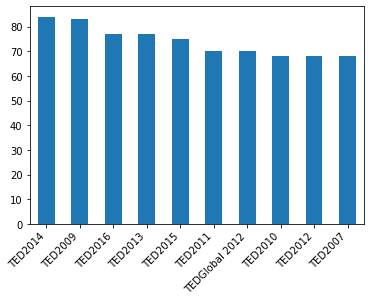

Number of TEDx talks: 471


In [283]:
event_bar_plot = df['event'].value_counts().sort_values(ascending=False)[:10]
event_bar_plot.plot.bar(x = 'event', y = 'count')
plt.xticks(rotation=45, horizontalalignment='right')

print('Number of events: ' + str(df['event'].nunique()))
print('Number of TEDx events: ' + str(len(df[df['event'].str.lower().str.find('tedx')!=-1]['event'].unique())))

plt.show()
print('Number of TEDx talks: ' + str(len(df[df['event'].str.lower().str.find('tedx')!=-1]['event'])))

Number of events with only one talk 163


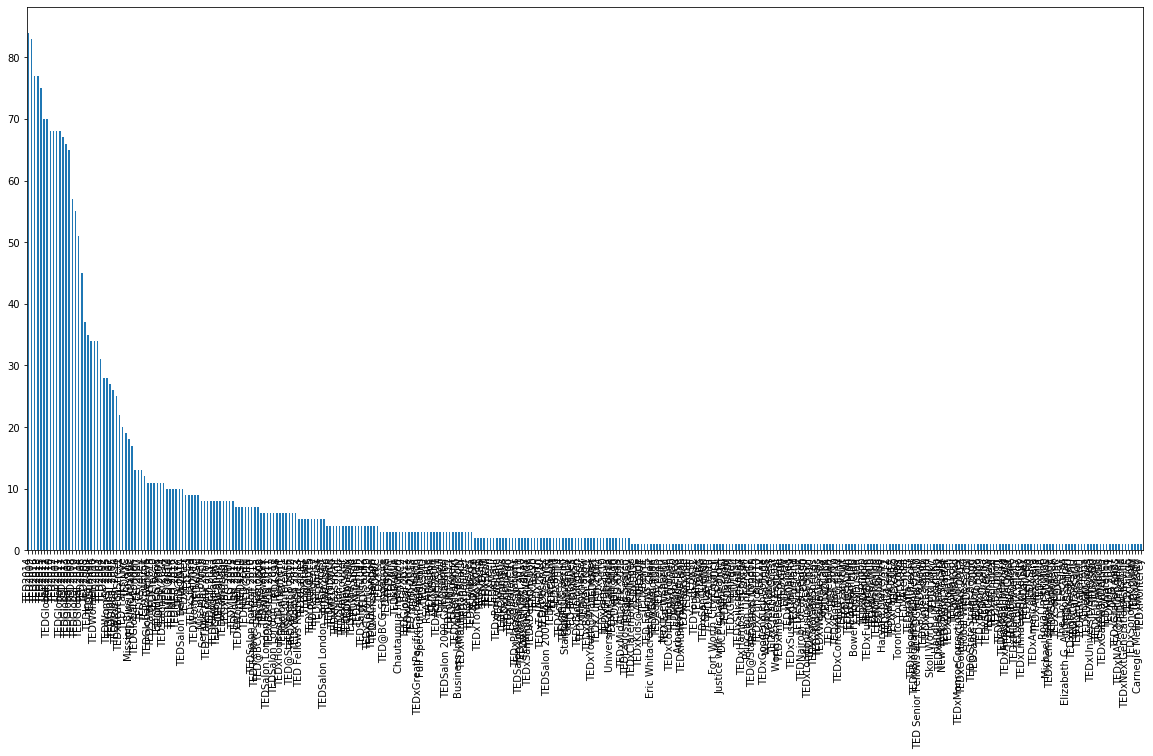

In [284]:
event_bar_plot = df['event'].value_counts().sort_values(ascending=False)
event_bar_plot.plot.bar(x = 'event', y = 'count', figsize=(20, 10))

print('Number of events with only one talk ' + str((df['event'].value_counts()==1).sum()))

### languages
Sadly, this just tells us the number of languages the talk is available in, and not a list of languages.</br>
Questions:
<ol>
    <li>What's the distribution of languages?</li>
</ol>

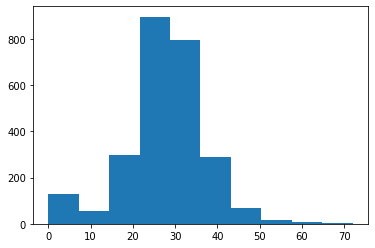

In [285]:
df['languages'].hist(grid=False)

### film_date and published_date
Will analyze the years of the film and published dates.</br>
Questions:
<ol>
    <li>How many ted talks are each year?</li>
    <li>Difference between the date a talk was filmed and the date it was published</li>
    <li>Show the growth over the years</li>
    <li>Oldest talk</li>
</ol>

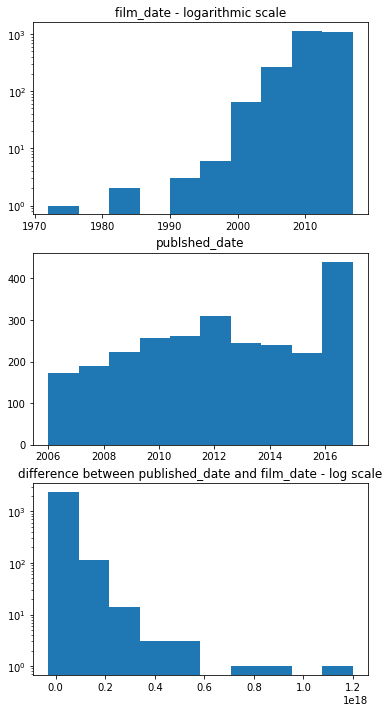

In [286]:
fig, ax = plt.subplots(3, 1, figsize=(6,12))
ax[0].hist(df['film_date'].dt.year)
ax[0].set_yscale('log')
ax[0].set_title('film_date - logarithmic scale')
ax[1].hist(df['published_date'].dt.year)
ax[1].set_title('publshed_date')
ax[2].hist(( df['published_date'] - df['film_date']).astype(int))
ax[2].set_title('difference between published_date and film_date - log scale')
ax[2].set_yscale('log')
plt.show()

In [287]:
# Oldest talk
df.iloc[df['film_date'].dt.year.idxmin()]

name                               Viktor Frankl: Why believe in others
title                                             Why believe in others
main_speaker                                              Viktor Frankl
speaker_occupation                    Psychiatrist, neurologist, author
num_speaker                                                           1
description           In this rare clip from 1972, legendary psychia...
duration                                                        4.36667
number_of_words                                                       0
movie_sentiment                                                0.504571
twitter_sentiment                                                     1
speed_of_speech                                                       0
transcript                                                             
event                                               Toronto Youth Corps
languages                                                       

### tags
Questions:
<ol>
    <li>How many talks belong to each tag?</li>
    <li>Most popular 30 tags</li>
</ol>

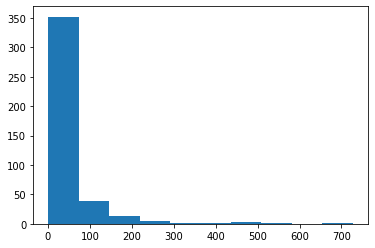

In [288]:
tags_count = pd.Series([y for x in df['tags'] for y in x]).value_counts()
tags_count.hist(grid=False)
plt.show()

In [289]:
print('Total number of tags: ' + str(tags_count.shape[0]))

Total number of tags: 416


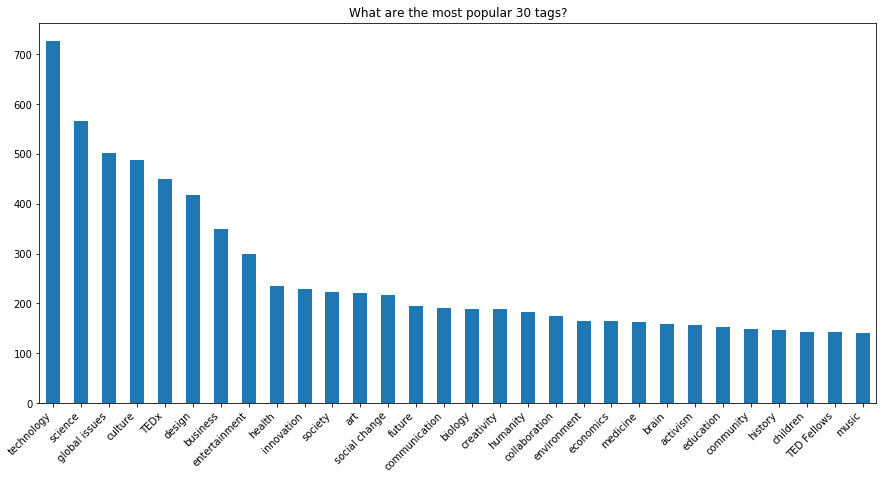

In [290]:
tags_count.sort_values(ascending=False)[:30].plot.bar(figsize=(15,7))
plt.title('What are the most popular 30 tags?')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

### views
Questions:
<ol>
    <li>What is the distribution of views?</li>
    <li>First 10 talks in terms of number of views</li>
</ol>

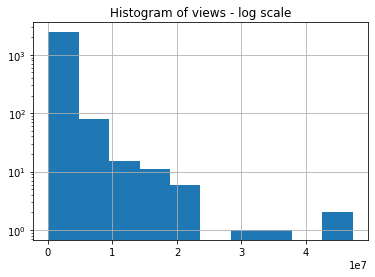

In [291]:
df['views'].hist()
plt.yscale('log')
plt.title('Histogram of views - log scale')
plt.show()

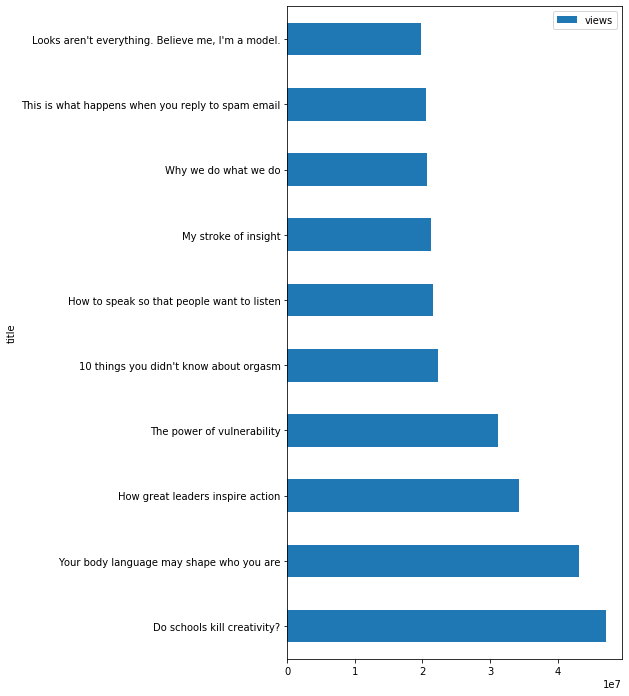

Total number of views: 4342375104


In [292]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))

bar_plot0 = df[['title', 'views']].sort_values(by='views', ascending=False)[:10]
bar_plot0.plot.barh(x='title', y='views', ax=ax)

plt.show()
print('Total number of views: ' + str(df['views'].sum()))

### comments
Questions:
<ol>
    <li>What is the distribution of comments?</li>
    <li>Which talks have the most comments? First 10</li>
</ol>

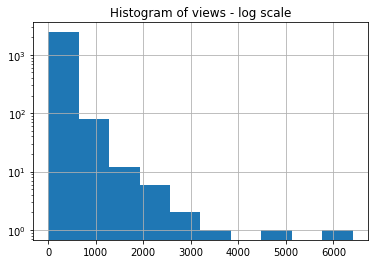

In [293]:
df['comments'].hist()
plt.yscale('log')
plt.title('Histogram of views - log scale')
plt.show()

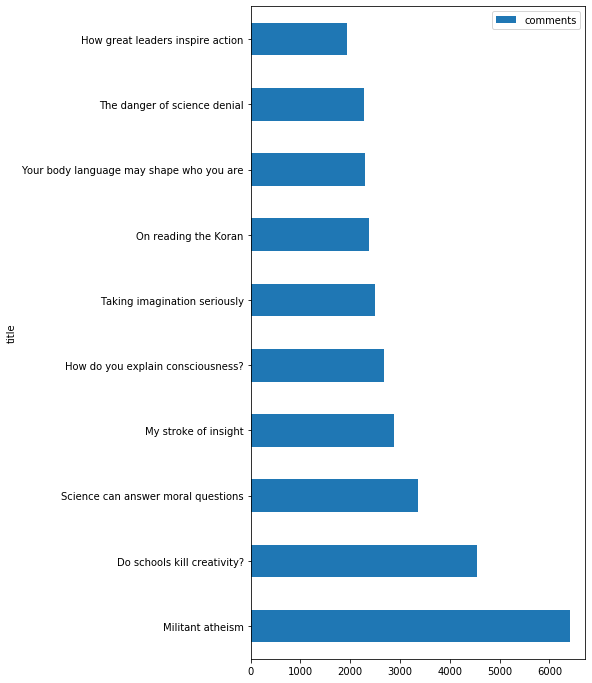

In [294]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))

bar_plot0 = df[['title', 'comments']].sort_values(by='comments', ascending=False)[:10]
bar_plot0.plot.barh(x='title', y='comments', ax=ax)

plt.show()

### ratings
Questions:
<ol>
    <li>What is the distribution of ratings? Count for each tag how many talks have it at least once.</li>
    <li>For each talk take the rating with the most counts.</li>
</ol>

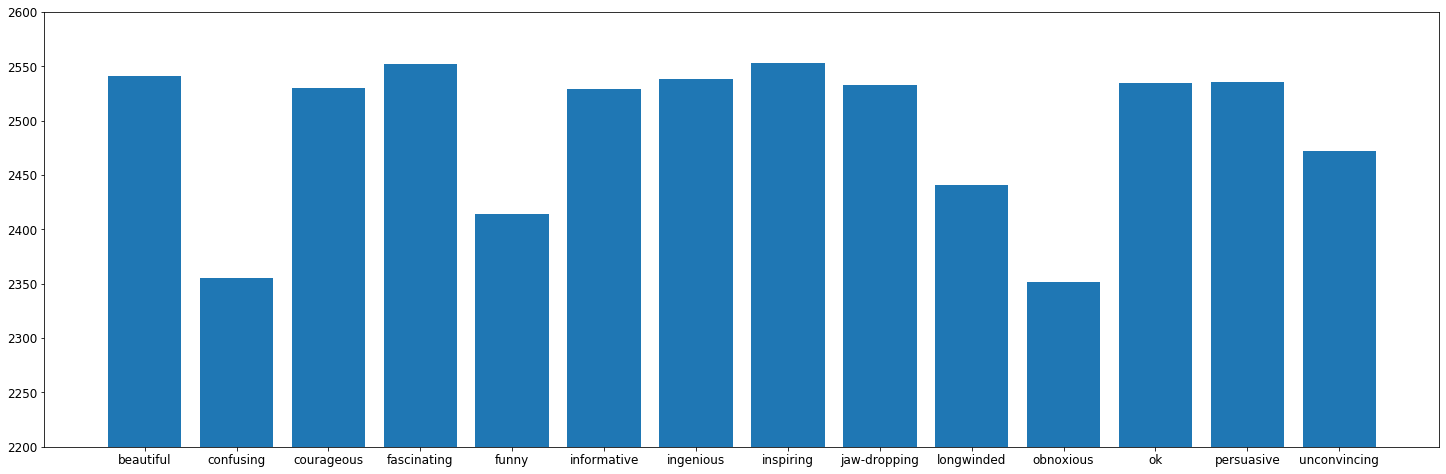

In [295]:
ratings_counts = {}

for name in ratings_name:
    ratings_counts[name] = df[df[name]>1].shape[0]
    
plt.figure(figsize=(25,8))
plt.rcParams.update({'font.size': 12})
plt.bar(range(len(ratings_counts)), list(ratings_counts.values()), align='center')
plt.xticks(range(len(ratings_counts)), list(ratings_counts.keys()))
plt.ylim(2200, 2600)
plt.show()

In [296]:
df.dtypes

name                          object
title                         object
main_speaker                  object
speaker_occupation            object
num_speaker                    int64
description                   object
duration                     float64
number_of_words                int64
movie_sentiment              float64
twitter_sentiment            float64
speed_of_speech              float64
transcript                    object
event                         object
languages                      int64
film_date             datetime64[ns]
published_date        datetime64[ns]
tags                          object
views                          int64
url                           object
ratings                       object
comments                       int64
related_talks                 object
beautiful                    float64
confusing                    float64
courageous                   float64
fascinating                  float64
funny                        float64
i

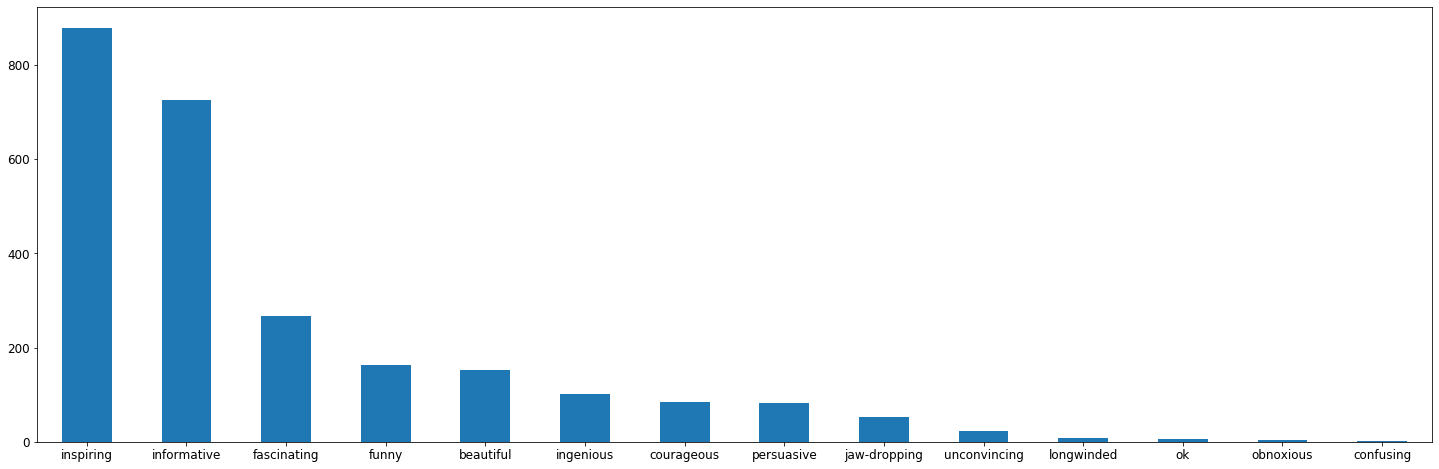

In [297]:
overall_rating = {
    'talk_name': [],
    'best_rating': []
}
for index, talk in df.iterrows():
    overall_rating['talk_name'].append(talk['name'])
    best_rating = talk[ratings_name].astype(float)
    overall_rating['best_rating'].append(best_rating.idxmax())

plt.figure(figsize=(25,8))
overall_rating = pd.DataFrame.from_dict(overall_rating)
overall_rating['best_rating'].value_counts().plot(kind='bar', rot=0)
plt.show()

## Part C. Analyzing the transcript dataset 

In [38]:
transcripts = pd.read_csv('data/transcripts.csv')
transcripts.dtypes
display(transcripts.head(5))

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


This dataset can be joined with the ted_talks one by using the url column. The transcript contains the speaker words + gestures, even what the music was playing. Will require some work as: what do we define as a word? Should we discard everything which is not what the speaker has said

In [39]:
transcripts['transcript'][0]

'Good morning. How are you?(Laughter)It\'s been great, hasn\'t it? I\'ve been blown away by the whole thing. In fact, I\'m leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we\'ve had and in all of the people here. Just the variety of it and the range of it. The second is that it\'s put us in a place where we have no idea what\'s going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don\'t you? I find this very interesting. If you\'re at a dinner party, and you say you work in education — Actually, you\'re not often at dinner parties, frankly.(Laughter)If you work in education, you\'re not asked.(Laughter)And you\'re never asked back, curiously. That\'s strange to me. But if you are, and you say to somebody, you

## Part D. Defining a new distance between talks


In [48]:
all_tags = df['tags'].values.tolist()
all_tags = [item.lower() for sublist in all_tags for item in sublist]

# Keep unique tags
all_tags = list(set(all_tags))


In [ ]:
def compute_similar(x, y):
    

In [49]:
n = df.shape[0]
similar = np.zeros((n, n))
for i in range(0, n):
    for j in range(i+1, n):
        similar[i][j] = compute_similar(df.iloc[i], df.iloc[j])

SyntaxError: unexpected EOF while parsing (<ipython-input-49-e0e0ec026b82>, line 2)

In [43]:
df.iloc[12]['description']

'Accepting the 2006 TED Prize, Dr. Larry Brilliant talks about how smallpox was eradicated from the planet, and calls for a new global system that can identify and contain pandemics before they spread.'